# Classification

### Import Packages

In [1]:
!pip install bayesian-optimization

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import itertools
import gensim

import nltk
from nltk.tokenize import word_tokenize  
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC  
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from bayes_opt import BayesianOptimization
from tqdm import tqdm
tqdm.pandas(desc="progress-bar") 
from gensim.models.doc2vec import TaggedDocument

from xgboost import XGBClassifier

p_stemmer = PorterStemmer() # initialize PorterStemmer

# Set seed for RNG
SEED = 12

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xiaoy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xiaoy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\xiaoy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\xiaoy\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Fetching from Github

After further manual data-preprocessing, raw dataset is uploaded to Github and retrieved via url link.

In [2]:
# Retrieve dataset via url link
# Github Repo: https://github.com/X-Yang98/CE4045-NLP
overall_url = "https://raw.githubusercontent.com/xiao-yangg/CE4045-NLP/main/combined_dataset.csv"

overall_df = pd.read_csv(overall_url, encoding='latin') # train and test dataset

In [3]:
# Sanity check for any duplicates
overall_df.drop_duplicates(['tweet'], inplace=True)

# Add index column for identification
overall_df['index'] = list(overall_df.index)

Inter-annotator agreement for evaluation dataset.

In [4]:
no_disagreements = len(overall_df[((overall_df['label_1'] != overall_df['label_2']) | 
                                (overall_df['label_2'] != overall_df['label_3']) |
                                (overall_df['label_3'] != overall_df['label_1'])
                               )])

print("Inter-annotator agreement is {}%.".format((len(overall_df) - no_disagreements)/len(overall_df)*100))

Inter-annotator agreement is 89.29166666666667%.


General function to display sentiment and sentence length distribution.

In [5]:
def show_distribution(label, tweets, name):
    plt.figure(figsize=(18,6))

    # Bar graph visualisation of sentiment distribution
    plt.subplot(1,2,1)
    sns.countplot(x=label)
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.title("Sentiments Distribution in " + name + " Dataset")

    # Bar graph visualisation of sentence length distribution
    plt.subplot(1,2,2)
    sns.histplot([len(s) for s in tweets], bins=100)
    plt.xlabel("Sentence Length")
    plt.ylabel("Count")
    plt.title("Sentence Length Distribution in " + name + " Dataset")

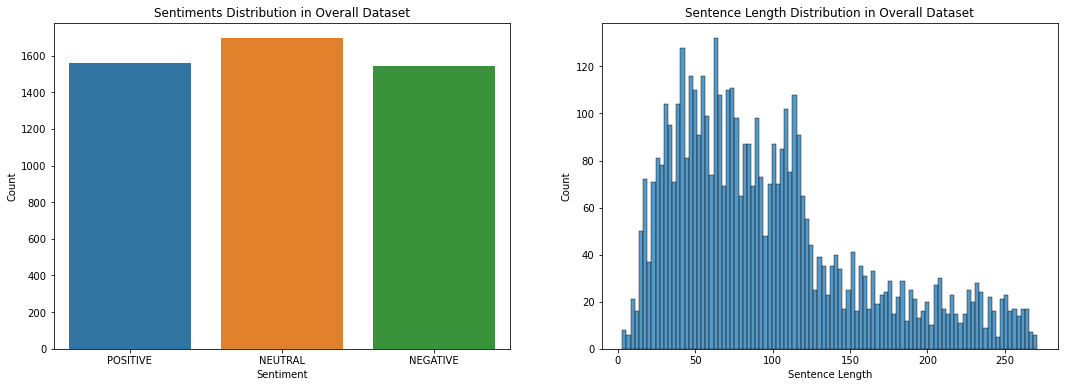

In [6]:
show_distribution(overall_df['final_label'], overall_df['tweet'], "Overall")

### Text Normalization


In [7]:
# Tokenization
def tokenize(text):
    return word_tokenize(text)

# Removal of Stopwords
def remove_stopword(text):
    nltk_tokenList = tokenize(text) # tokenize

    filtered_sentence = [] # sentence without stopwords
    nltk_stop_words = set(stopwords.words("english"))
    for w in nltk_tokenList:  
        if w not in nltk_stop_words:  
            filtered_sentence.append(w)
    
    return ' '.join(filtered_sentence)

# Stemming
def stemming(token_list):
    stemmed_list = []
    for word in token_list:
        stemmed_list.append(p_stemmer.stem(word))

    return stemmed_list

# Lemmatization
def lemmatization(stemmed_list):
    wordnet_lemmatizer = WordNetLemmatizer()
    lemma_list = []
    for word in stemmed_list:
        lemma_list.append(wordnet_lemmatizer.lemmatize(word))

    return lemma_list

# Combination of stemming and lemmatization
def nltk_process(text):
    nltk_tokenList = tokenize(text) # tokenize
    nltk_stemmedList = stemming(nltk_tokenList) # stemmed
    nltk_lemmaList = lemmatization(nltk_stemmedList) # lemma

    return ' '.join(nltk_tokenList)

Apply normalization to dataset.

In [8]:
def normalize_df(df):    
    df['no_stopword_tweet'] = df['tweet'].apply(remove_stopword) # obtain tweet without stopwords
    df['normalize_tweet'] = df['no_stopword_tweet'].apply(nltk_process) # tweet with no stopwords go through stemming and lemma

    # New dataframe of text normalized tweets
    columns_titles = ['normalize_tweet','final_label', 'index']
    return df.reindex(columns=columns_titles)

In [9]:
norm_df = normalize_df(overall_df)

### Split into train and test datasets

In [10]:
X_train, X_test, y_train, y_test = train_test_split(norm_df['normalize_tweet'], # tweet
                                                    norm_df[['final_label', 'index']], # label, index
                                                    test_size=0.25, # test size 25% 
                                                    random_state = SEED,
                                                    shuffle=True,
                                                    stratify=norm_df['final_label']) # ensure even proportion of Positive, Negative, Neutral in test data

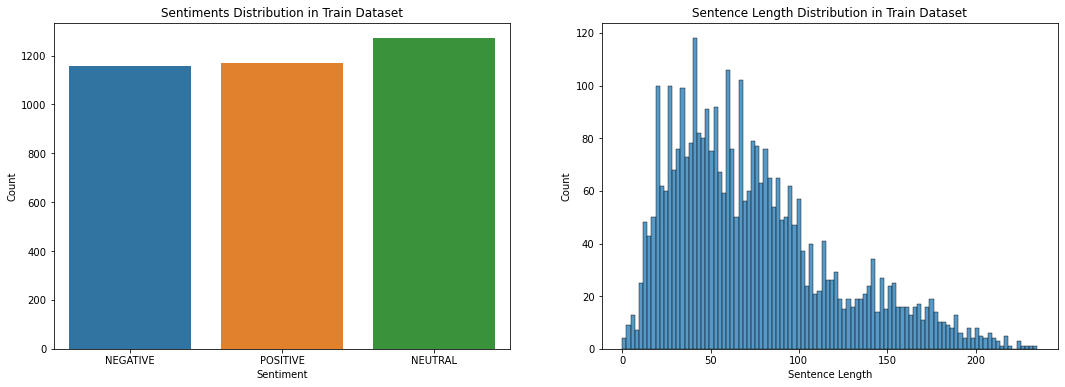

In [11]:
show_distribution(y_train['final_label'], X_train, "Train")

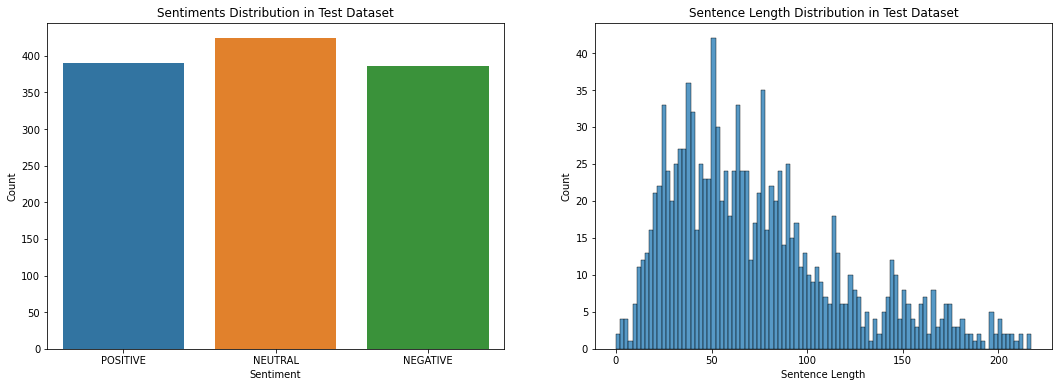

In [12]:
show_distribution(y_test['final_label'], X_test, "Test")

### Model Helpers

In [13]:
# Remove index
y_train = y_train['final_label']
y_test = y_test['final_label']

#### Vectorizers

TF-IDF Vectorizer

In [14]:
tfidf_vec = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7)  

# Using training data to transform text into counts of features for each tweet
tfidf_vec.fit(X_train)

# uncomment this if planning to run streamlit as this vectorizer will be loaded in the UI
pickle.dump(tfidf_vec, open("vectorizer.pkl", "wb"))

#### Plots

General function for showing evaluation metrics.

In [15]:
def show_metrics(y_test, y_pred):

    # Adding classes names for interpretation
    classes_names = ['NEGATIVE', 'NEUTRAL', 'POSITIVE']
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                      columns=classes_names, index=classes_names)
                      
    # Visualize confusion matrix
    sns.heatmap(cm, annot=True, fmt='d');

    # Print classification report
    print(classification_report(y_test, y_pred))

# Innovations

### Ensemble Classification




#### Import Packages

In [17]:
from sklearn.ensemble import StackingClassifier

#### Stacked Classifier

In [27]:
X_train_dtm = tfidf_vec.transform(X_train)
X_test_dtm = tfidf_vec.transform(X_test)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.fit_transform(y_test)

In [28]:
optimal_xgb_depth = 12
optimal_et_depth = 77

In [29]:
stacked_estimators = [
                      ('xgb', XGBClassifier(max_depth = optimal_xgb_depth, n_estimators = 250, random_state = SEED)),
                      ('et', ExtraTreesClassifier(max_depth = optimal_et_depth, n_estimators = 250, random_state = SEED)),
                      ('svm', SVC(C = 1, gamma = 1, kernel = 'rbf')),
                      ('nb', MultinomialNB(alpha = 1))
                     ]

In [30]:
final_est = LogisticRegression(solver = 'saga', multi_class = 'multinomial', random_state = SEED)
stacked_clf = StackingClassifier(estimators = stacked_estimators,
                                final_estimator = final_est,
                                n_jobs = 1)

In [31]:
stacked_clf.fit(X_train_dtm, y_train_encoded)
y_pred_encoded = stacked_clf.predict(X_test_dtm)
y_pred = le.inverse_transform(y_pred_encoded)

acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print('Accuracy Score: ', acc, '%', sep='')
print('F1 Score: ', f1, '%', sep='')

# uncomment this if planning to run streamlit as this model will be loaded in the UI as a sample
pickle.dump(stacked_clf, open("stacked_classifier.pkl", "wb"))

Accuracy Score: 69.83333333333334%
F1 Score: 69.77155239486137%


              precision    recall  f1-score   support

    NEGATIVE       0.68      0.73      0.70       386
     NEUTRAL       0.71      0.73      0.72       424
    POSITIVE       0.71      0.64      0.67       390

    accuracy                           0.70      1200
   macro avg       0.70      0.70      0.70      1200
weighted avg       0.70      0.70      0.70      1200



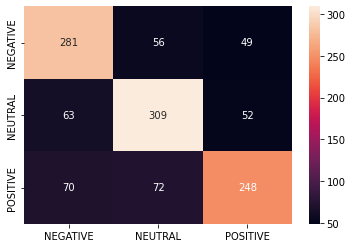

In [32]:
show_metrics(y_test, y_pred)

# Streamlit UI



### Import Packages

In [33]:
!pip install -q streamlit
!pip install pyngrok

from pyngrok import ngrok

# Authenticate
ngrok.set_auth_token("2FqU82IZ9ZI6E5dgzkFV3T8ln1o_71PCqcz1mN4uKfS7QbZco")

  Created wheel for pyngrok: filename=pyngrok-5.1.0-py3-none-any.whl size=19006 sha256=0408a97f93d627ab61d9544dc98f1f9d3668f42d1ecf881cdb95f98bc1c80b00
  Stored in directory: c:\users\xiaoy\appdata\local\pip\cache\wheels\a8\05\30\c9d9f2417546c7a7c329f5bba09e2cfba9991c030ad8bfb043
Successfully built pyngrok


### Application

In [34]:
%%writefile streamlit_app.py 
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import re
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud  

def add_bg_from_url():
    st.markdown(
         f"""
         <style>
         .stApp {{
             background-image: url("https://media.idownloadblog.com/wp-content/uploads/2022/08/Apple-Far-Out-Event-Wallpaper-for-6K-desktop.png");
             background-size: cover;
         }}
         </style>
         """,
         unsafe_allow_html=True
     )

add_bg_from_url() 

#############
# [BACKEND] #
#############
# Data Pre-processing (extracted)
def removePunctuations(tweet):
    return re.sub(r'[^\w\s]', '', tweet)
def removeNumbers(tweet):
    return re.sub(r'[0-9]', '', tweet)
def dataPreprocessing(tweet):
    tweet = removePunctuations(tweet)
    tweet = removeNumbers(tweet)
    return tweet.lower().strip()
def tokenize(text):
    return word_tokenize(text)
def remove_stopword(text):
    nltk_tokenList = tokenize(text)
    filtered_sentence = []
    nltk_stop_words = set(stopwords.words("english"))
    for w in nltk_tokenList:  
        if w not in nltk_stop_words:  
            filtered_sentence.append(w)
    if len(filtered_sentence) <= 13:
        return text
    return ' '.join(filtered_sentence)


# Fixed list of categories about Apple event
list_category = ["appleevent","iphone","watch"]

# Find category of tweet
def find_category_keyword(list_text, keyword):
    for i in list_text:
        if keyword in i:
            return True     
    return False

# Remove categorical keyword from tweet
def remove_category_keyword(list_text):
    i = 0
    while i < len(list_text):
        for j in list_category:
            if j in list_text[i]:
                list_text.pop(i)
                if len(list_text) == 0:
                    break
                i -= 1
        i += 1   
    return ' '.join(list_text) # join back tweet

# Retrieve sentiment data
overall_url = "https://raw.githubusercontent.com/xiao-yangg/CE4045-NLP/main/combined_dataset.csv"
df = pd.read_csv(overall_url, encoding='latin')
df['no_stopword_tweet'] = df['tweet'].apply(remove_stopword)
df['tokenize'] = df['no_stopword_tweet'].apply(tokenize)
for category in list_category:
    df[category] = df['tokenize'].apply(find_category_keyword, args=(category,))
df['no_category_tweet'] = df['tokenize'].apply(remove_category_keyword)

# WordCloud generator function
def generate_wordcloud(df):
    string = pd.Series(df).str.cat(sep=' ')

    wordcloud = WordCloud(width=1600, height=800, 
                      max_font_size=200, max_words=50, collocations=False, 
                      background_color='black').generate(string)

    fig = plt.figure(figsize=(40,30))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    return fig
  

#############
#[FRONTEND] #
#############
st.title("Twitter Sentiment Analysis on #AppleEvent2022")

# Loading model and vectorizer into streamlit
load_model_state = st.text("Loading trained classifier...")
vectorizer = pickle.load(open("/content/vectorizer.pkl", "rb"))
model = pickle.load(open("/content/stacked_classifier.pkl", "rb"))
load_model_state.text("Trained classifier loaded!")

# Upload training csv/txt file
st.subheader("Upload test file to classify")
with st.form("placeholder", clear_on_submit = True):
    uploaded_file = st.file_uploader("Choose test file")
    uploaded_button = st.form_submit_button("Upload and classify")
    if uploaded_button and uploaded_file is not None:
        data = uploaded_file.getvalue().decode('utf-8').splitlines()
        headers = data[0].split(sep = ",")
        data_dict = {header : [] for header in headers}
        for i in range(1, len(data)):
            split_data = data[i].split(sep = ",")
            for e in range(len(headers)):
                data_dict[headers[e]].append(split_data[e])
        test_df = pd.DataFrame.from_dict(data_dict)

        test_df = test_df.drop_duplicates()
        test_df = test_df.dropna()
        st.text("Unclassified test dataframe:")
        st.write(test_df)

        classify_state = st.text("Classifying test data...")
        x_test = vectorizer.transform(test_df[headers[0]])
        y_pred = model.predict(x_test)
        classified_df = test_df.copy()
        classified_df["predicted_labels"] = y_pred
        classify_state.text("Displaying classified test data")
        st.text("Classified test dataframe:")
        st.write(classified_df)

    elif uploaded_button:
        st.write("Please upload a valid csv file with columns (tweets, label)")

# Taking in a query sentence as input
raw_sentence = st.text_input(label="Ask me about #AppleEvent2022!", placeholder="And I will give you a surprise!")
raw_category = st.selectbox('Which hashtag?', ('No Hashtag', '#AppleEvent2022', '#iPhone14'))
state = st.button("Find out")
st.write("*our dataset consist of tweets scraped on 26 September 2022")

# Analyse Sentiment of input by user
if state:
    if not raw_category: # check if 1 of hashtags is selected
        st.write("Select a hashtag!")
    else:
        # Process input
        sentence = dataPreprocessing(raw_sentence)

        # Model prediction on sentence sentiment
        y_pred = model.predict(vectorizer.transform([sentence])) 
        sentiment = y_pred[0]
        sentiment = 'POSITIVE' if sentiment == 2 else 'NEGATIVE' if sentiment == 0 else 'NEUTRAL'

        # Find category
        category = ''
        if raw_category != 'No Hashtag':
            category = removeNumbers(raw_category[1:].lower()) # lowercase + remove numbers

        # Filter dataset for similar sentiments base on category
        sentiment_df = df.loc[df['final_label'] == sentiment]

        if raw_category != 'No Hashtag':
            user_df = sentiment_df.loc[sentiment_df[category]]
            word_cloud = generate_wordcloud(user_df['no_category_tweet'])
        else:
            word_cloud = generate_wordcloud(sentiment_df['no_category_tweet'])

        word_cloud_state = st.text("Generating word cloud on similar sentiments...")
        st.pyplot(word_cloud)
        word_cloud_state.text("Your sentiment is {}.".format(sentiment))
        st.write("{}% of people on Twitter in our dataset* thinks like you.".format(round(len(sentiment_df)/len(df)*100), 2))

Writing streamlit_app.py


**Google Colab**

Run to start Streamlit UI. (Click left link)

In [ ]:
!nohup streamlit run streamlit_app.py --server.port 80 &
public_url = ngrok.connect(port='80')
public_url

Kill process id of Streamlit UI if error is thrown due to multiple running applications.

In [ ]:
ngrok.kill()

**Local Machine**

1. Go to command prompt
2. Locate 'streamlit_app.py' in same directory
3. Type 'streamlit run streamlit_app.py'